## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-03 22:17:41--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178.21K  --.-KB/s    in 0.03s   

2021-10-03 22:17:41 (5.89 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [34]:
df.head().T
strings = list(df.dtypes[df.dtypes == 'object'].index)
print(strings)
numerical = [c for c in df.columns if c not in strings and c != 'default']
print(numerical)

['home', 'marital', 'records', 'job']
['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [47]:
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size=0.2, random_state=1)
train, val = train_test_split(train_val, test_size=0.25, random_state=1)
print(len(train), len(val), len(test))

2672 891 891


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [48]:
from sklearn.metrics import roc_auc_score
auc_scores = []
for numerical_var in numerical:
    auc_score = roc_auc_score(train["default"], train[numerical_var])
    if auc_score < 0.5:
        auc_score = roc_auc_score(train["default"], -train[numerical_var])
    auc_scores.append((numerical_var, auc_score))
    
print(sorted(auc_scores, key=lambda x : x [1]))

[('expenses', 0.5009184217217011), ('price', 0.5043329862114843), ('debt', 0.5047829675783548), ('time', 0.5608662489595051), ('age', 0.5732933272499939), ('amount', 0.5910773431595518), ('assets', 0.6486042567122802), ('income', 0.682006666132633), ('seniority', 0.7093778624491943)]


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [56]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

training_features = ['seniority', 'income', 'assets', 'records', 'job', 'home']

train_dict = train[training_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
y_train = train["default"]
print(X_train)

val_dict = val[training_features].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_val = val["default"]

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_train, y_train)
y_val_pred = model.predict_proba(X_val)[:,1]
print(y_val_pred)
roc_auc_score(y_val, y_val_pred)

[[0.0e+00 0.0e+00 0.0e+00 ... 1.0e+00 0.0e+00 1.2e+01]
 [0.0e+00 0.0e+00 1.0e+00 ... 1.0e+00 0.0e+00 4.0e+00]
 [6.0e+03 0.0e+00 0.0e+00 ... 1.0e+00 0.0e+00 0.0e+00]
 ...
 [0.0e+00 0.0e+00 0.0e+00 ... 0.0e+00 1.0e+00 9.0e+00]
 [3.0e+03 0.0e+00 0.0e+00 ... 1.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 ... 1.0e+00 0.0e+00 8.0e+00]]
[1.96864314e-01 1.17566872e-01 2.69819055e-01 1.23272338e-01
 4.14165672e-02 6.03395745e-01 8.47304883e-01 2.30828468e-01
 9.20154388e-01 3.40258877e-01 3.19615976e-01 6.28632920e-02
 4.05809735e-01 4.06877803e-01 1.01942248e-01 7.06995276e-02
 3.02017038e-02 2.74913047e-01 7.92667940e-01 5.23974453e-02
 4.90722153e-01 1.33305263e-01 7.04823910e-02 1.78498053e-02
 4.18152408e-01 5.33852409e-01 5.31609105e-01 1.02859953e-01
 4.30786585e-01 2.42858519e-02 2.25437343e-01 4.93559218e-02
 3.15445298e-01 1.23847857e-01 6.97466687e-01 8.41052013e-02
 5.28889504e-02 6.76631171e-01 1.11294103e-01 1.21434289e-01
 3.95984726e-01 1.00225343e-01 1.12215659e-01 1.766222

0.8120879813449298

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


/var/folders/7s/5h000n6s2z75cbf4y33k39y40000gn/T/ipykernel_56864/3644441012.py:19: RuntimeWarning: invalid value encountered in long_scalars
  scores.append((t, tp, fp, fn, tn, (tp / (tp+fp)), (tp / (tp + fn))))


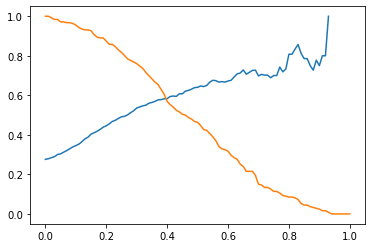

In [67]:
thresholds = np.linspace(0, 1, 101)
print(thresholds)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_val_pred >= t)
    predict_negative = (y_val_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn, (tp / (tp+fp)), (tp / (tp + fn))))
    
precisions = list(map(lambda x : x[5], scores))
recalls = list(map(lambda x : x[6], scores))
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [73]:
f1s = []
for score in scores:
    precision = score[5]
    recall = score[6]
    f1s.append((score[0], 2*((precision * recall) / (precision + recall))))

print(f1s)
print(sorted(f1s, key=lambda x:x[1]))

[(0.0, 0.43271767810026385), (0.01, 0.4365572315882875), (0.02, 0.442429737080689), (0.03, 0.4477335800185014), (0.04, 0.46051379638439577), (0.05, 0.46317829457364346), (0.06, 0.47279920870425324), (0.07, 0.4812942366026289), (0.08, 0.4917355371900827), (0.09, 0.5015873015873017), (0.1, 0.5075593952483801), (0.11, 0.5138427464008859), (0.12, 0.5257142857142857), (0.13, 0.5394581861012957), (0.14, 0.5478468899521531), (0.15, 0.562268803945746), (0.16, 0.5652724968314322), (0.17, 0.5699481865284974), (0.18, 0.5778364116094987), (0.19, 0.5879194630872484), (0.2, 0.5906593406593407), (0.21, 0.5952045133991537), (0.22, 0.6054519368723099), (0.23, 0.6072992700729927), (0.24, 0.6107784431137725), (0.25, 0.6137404580152672), (0.26, 0.6108527131782946), (0.27, 0.6117274167987321), (0.28, 0.617124394184168), (0.29, 0.6217105263157895), (0.3, 0.6285714285714286), (0.31, 0.6279863481228668), (0.32, 0.6273830155979202), (0.33, 0.6219081272084805), (0.34, 0.6220614828209765), (0.35000000000000003, 

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [83]:
from sklearn.model_selection import KFold

def train(df_train, y_train, C=1.0):
    dicts = df_train[training_features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[training_features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(train_val):
    df_train = train_val.iloc[train_idx]
    df_val = train_val.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
print(scores)
print(np.std(scores))

[0.8256212256212256, 0.8254077031563474, 0.789298525308888, 0.8153421373265731, 0.8054696294614563]
0.013669069470482898


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [84]:
C_candidates = [0.01, 0.1, 1, 10]
for C in C_candidates:
        kfold = KFold(n_splits=5, shuffle=True, random_state=1)
        scores = []

        for train_idx, val_idx in kfold.split(train_val):
            df_train = train_val.iloc[train_idx]
            df_val = train_val.iloc[val_idx]

            y_train = df_train.default.values
            y_val = df_val.default.values

            dv, model = train(df_train, y_train, C=C)
            y_pred = predict(df_val, dv, model)

            auc = roc_auc_score(y_val, y_pred)
            scores.append(auc)
            
        print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.809 +- 0.013
C=0.1 0.813 +- 0.014
C=1 0.812 +- 0.014
C=10 0.814 +- 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.